# SVM Modeling and hyperparameter tuning




In [1]:
import pandas as pd
import plotly
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import timeit
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve
import warnings
warnings.filterwarnings(action='once')

In [47]:
import os
os.getcwd()

'/Users/ej7793/Documents/FlightDelay/src'

In [2]:


df = pd.read_csv('../Data/feature_engineered.csv')

In [49]:
df.describe()

,Saturday,Tuesday_Wednesday,CARRIER_rank,ORIGIN_rank,DEST_rank,LATE_NIGHT,DEP_HOUR_rank,DEP_DEL15,ARR_DEL15
count,599235.000000,599235.000000,599235.000000,599235.000000,599235.000000,599235.000000,599235.000000,599235.000000,599235.000000
mean,0.106010,0.287562,6.354168,3.474976,3.052632,0.038092,3.283166,0.135917,0.137317
std,0.307851,0.452626,4.872752,2.177318,2.288243,0.191418,2.106907,0.342700,0.344182
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,2.000000,2.000000,1.000000,0.000000,2.000000,0.000000,0.000000
50%,0.000000,0.000000,6.000000,3.000000,2.000000,0.000000,3.000000,0.000000,0.000000
75%,0.000000,1.000000,10.000000,5.000000,4.000000,0.000000,5.000000,0.000000,0.000000
max,1.000000,1.000000,16.000000,9.000000,9.000000,1.000000,9.000000,1.000000,1.000000


In [50]:
df.dtypes

Saturday               int64
Tuesday_Wednesday      int64
CARRIER_rank           int64
ORIGIN_rank          float64
DEST_rank            float64
LATE_NIGHT             int64
DEP_HOUR_rank          int64
DEP_DEL15            float64
ARR_DEL15            float64
dtype: object

In [51]:
df.columns

Index(['Saturday', 'Tuesday_Wednesday', 'CARRIER_rank', 'ORIGIN_rank',
       'DEST_rank', 'LATE_NIGHT', 'DEP_HOUR_rank', 'DEP_DEL15', 'ARR_DEL15'],
      dtype='object')

In [52]:
df = df.sample(100000)

X_train, X_final_test = train_test_split(df,test_size=0.2, random_state= 2)
X_final_test.to_csv('../Data/testing_dataset.csv', index = False)
## within the training dataset, split the data into training dataset and testing/validation dataset
X_train, X_test = train_test_split(X_train,test_size=0.2, random_state= 2)
print('records in training dataset')
print(len(X_train))
print('records in validation dataset')
print(len(X_test))
print('records in final testing dataset')
print(len(X_final_test))

records in training dataset
64000
records in validation dataset
16000
records in final testing dataset
20000


In [53]:
predictors = ['Saturday', 'Tuesday_Wednesday', 'CARRIER_rank', 'ORIGIN_rank',
       'DEST_rank', 'LATE_NIGHT', 'DEP_HOUR_rank', 'DEP_DEL15']
target = 'ARR_DEL15'


In [78]:
def modelfit(estimator,data_train,data_test,predictors,target):
    start = timeit.default_timer()
    #fitting model
    estimator.fit(data_train[predictors],data_train.loc[:,target])
    #train data prediction
    start1 = timeit.default_timer()
    train_pred=estimator.predict(data_train[predictors])
    stop1 = timeit.default_timer()
    #cross_validation score
    cv_score=cross_val_score(estimator,data_train[predictors],data_train.loc[:,target],cv=5,scoring='precision')

    #Print model report:
    print ("\nModel Report")
    print ("Accuracy on Train Data: %.4g" % metrics.accuracy_score(data_train.loc[:,target].values, train_pred))
    print ("Precision on Train Data: %.4g" % metrics.precision_score(data_train.loc[:,target].values, train_pred))
    print ("Recall on Train Data: %.4g" % metrics.recall_score(data_train.loc[:,target].values, train_pred))
    print ("F1 score on Train Data: %.4g" % metrics.f1_score(data_train.loc[:,target].values, train_pred))
    
    print ("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    start2 = timeit.default_timer()
    test_pred=estimator.predict(data_test[predictors])
    stop2 = timeit.default_timer()
    print ("Accuracy on Test Data: %.4g" % metrics.accuracy_score(data_test.loc[:,target].values, test_pred))  
    print ("Precision on Test Data: %.4g" % metrics.precision_score(data_test.loc[:,target].values, test_pred)) 
    print ("Recall on Test Data: %.4g" % metrics.recall_score(data_test.loc[:,target].values, test_pred)) 
    print ("F1 score on Test Data: %.4g" % metrics.f1_score(data_test.loc[:,target].values, test_pred)) 
    stop = timeit.default_timer()
    print('Total Time: ', stop - start)
    print('training time: ', stop1 - start1)
    print('testing time: ', stop2 - start2)
    return test_pred


In [55]:
X_test.ARR_DEL15.value_counts(normalize =True)

0.0    0.86625
1.0    0.13375
Name: ARR_DEL15, dtype: float64

In [56]:
## create learning curve ploting function

from sklearn.model_selection import learning_curve
##learning curve
# Obtain scores from learning curve function
# cv is the number of folds while performing Cross Validation
def plot_learning_curve(alg, X, y, scoring_metric, algorithm_name):
    sizes, training_scores, testing_scores = learning_curve(alg, X, y, cv=5, scoring= scoring_metric, train_sizes=np.linspace(0.01, 1.0, 30))

    # Mean and Standard Deviation of training scores
    mean_training = np.mean(training_scores, axis=1)
    Standard_Deviation_training = np.std(training_scores, axis=1)

    # Mean and Standard Deviation of testing scores
    mean_testing = np.mean(testing_scores, axis=1)
    Standard_Deviation_testing = np.std(testing_scores, axis=1)

    # dotted blue line is for training scores and green line is for cross-validation score
    plt.plot(sizes, mean_training, '--', color="b",  label="Training score")
    plt.plot(sizes, mean_testing, color="g", label="Cross-validation score")

    # Drawing plot
    plt.title("LEARNING CURVE FOR %s" % algorithm_name)
    plt.xlabel("Training Set Size"), plt.ylabel("%s Score" % scoring_metric), plt.legend(loc="best")
    plt.tight_layout()
    plt.show()
    return

In [57]:
# create validation curve ploting function


 
# Calculate accuracy on training and test set using the
# gamma parameter with 5-fold cross validation
def plot_validation_curve(alg,X, y, param_name, parameter_range, scoring_metric, algorithm_name):
    train_score, test_score = validation_curve(alg, X, y,
                                           param_name = param_name,
                                           param_range = parameter_range,
                                            cv = 5, scoring = scoring_metric)

    # Calculating mean and standard deviation of training score
    mean_train_score = np.mean(train_score, axis = 1)
    std_train_score = np.std(train_score, axis = 1)

    # Calculating mean and standard deviation of testing score
    mean_test_score = np.mean(test_score, axis = 1)
    std_test_score = np.std(test_score, axis = 1)

    # Plot mean accuracy scores for training and testing scores
    plt.plot(parameter_range, mean_train_score,
         label = "Training Score", color = 'b')
    plt.plot(parameter_range, mean_test_score,
       label = "Cross Validation Score", color = 'g')

    # Creating the plot
    plt.title("Validation Curve with %s" % algorithm_name)
    plt.xlabel("%s" % param_name)
    plt.ylabel("%s" % scoring_metric)
    plt.tight_layout()
    plt.legend(loc = 'best')
    plt.show()
    return

## Modeling

**SVM**

In [58]:
from sklearn.svm import SVC
svm = SVC(random_state =1)
y_pred=modelfit(svm, X_train, X_test,predictors,target)


Model Report
Accuracy on Train Data: 0.9315
Precision on Train Data: 0.7497
Recall on Train Data: 0.7463
F1 score on Train Data: 0.748
CV Score : Mean - 0.748 | Std - 0.006003 | Min - 0.7378 | Max - 0.756
Accuracy on Test Data: 0.9316
Precision on Test Data: 0.7352
Recall on Test Data: 0.764
F1 score on Test Data: 0.7493
Time:  742.7120475820011


**Learning curve**

Based on the learning curve, we can see that the training curve and the cross validation curve converges at 2000 samples

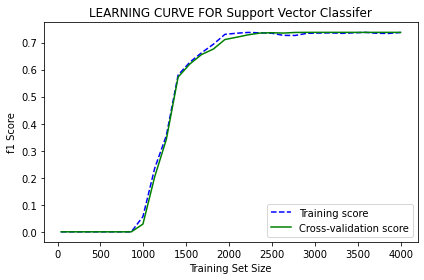

In [59]:
plot_learning_curve(svm, X, y, 'f1', 'Support Vector Classifer')

In [60]:
## sampling data to cut down run time 
X_train_test = X_train.sample(5000)
X = X_train_test[predictors]
y = X_train_test[target]

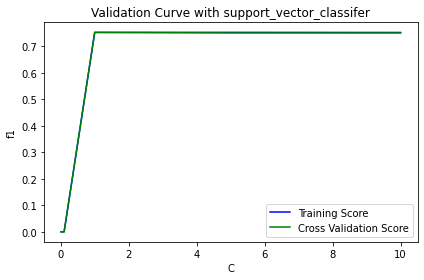

In [61]:
## validation curve
##C
## Choose C = 1

parameter_range = [0.01, 0.1, 1, 5, 10]
 
plot_validation_curve(svm,X, y, "C", parameter_range, "f1", 'support_vector_classifer')

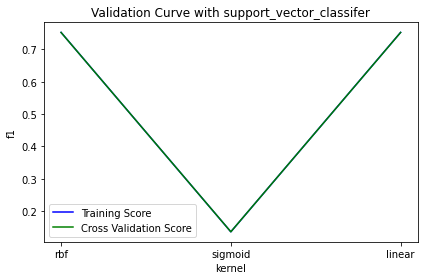

In [62]:
##Validation curve 
# Kernel
## no over fitting underfitting issues
## choose highest 
from sklearn.model_selection import validation_curve

parameter_range = ['rbf', 'sigmoid', 'linear']
plot_validation_curve(svm,X, y, "kernel", parameter_range, "f1", 'support_vector_classifer')



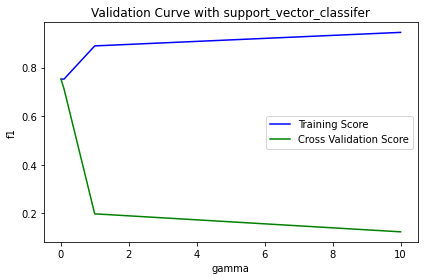

In [63]:
##Gamma
parameter_range = [0.01,0.1, 1, 10]
plot_validation_curve(svm,X, y, "gamma", parameter_range, "f1", 'support_vector_classifer')

In [64]:
svm.get_params().keys()

dict_keys(['C', 'break_ties', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape', 'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state', 'shrinking', 'tol', 'verbose'])

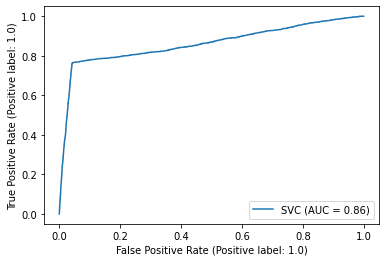

In [65]:
## ROC curve
from sklearn.metrics import confusion_matrix, classification_report, plot_roc_curve

plot_roc_curve(svm, X_test[predictors], X_test[target])

In [66]:
## hyperparameter tuning 
##GridSearch
from sklearn.model_selection import GridSearchCV
param_grid = {'gamma': [0.01,0.1, 1],
              'kernel': ['rbf', 'linear']}
grid_lr = GridSearchCV(estimator =svm, param_grid= param_grid, scoring='f1', 
                        refit=True, return_train_score=True) 
grid_lr.fit(X_train_test[predictors],X_train_test[target])


GridSearchCV(estimator=SVC(random_state=1),
             param_grid={'gamma': [0.01, 0.1, 1], 'kernel': ['rbf', 'linear']},
             return_train_score=True, scoring='f1')

In [67]:
print(grid_lr.best_estimator_)

print(grid_lr.best_params_)

SVC(gamma=0.01, random_state=1)
{'gamma': 0.01, 'kernel': 'rbf'}


In [68]:
svm.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

**New model after hyperparameter tuning**

In [82]:
svm_tuned = SVC(gamma=0.01, random_state = 1)
y_pred=modelfit(svm_tuned, X_train, X_test,predictors,target)


Model Report
Accuracy on Train Data: 0.9315
Precision on Train Data: 0.7497
Recall on Train Data: 0.7463
F1 score on Train Data: 0.748
CV Score : Mean - 0.7498 | Std - 0.009861 | Min - 0.734 | Max - 0.7634
Accuracy on Test Data: 0.9316
Precision on Test Data: 0.7352
Recall on Test Data: 0.764
F1 score on Test Data: 0.7493
Total Time:  446.12629305099836
training time:  68.91634751099627
testing time:  17.420425953008817


In [83]:
## compare with before hyper parameter tuning 
y_pred=modelfit(svm, X_train, X_test,predictors,target)


Model Report
Accuracy on Train Data: 0.9315
Precision on Train Data: 0.7497
Recall on Train Data: 0.7463
F1 score on Train Data: 0.748
CV Score : Mean - 0.7498 | Std - 0.009861 | Min - 0.734 | Max - 0.7634
Accuracy on Test Data: 0.9316
Precision on Test Data: 0.7352
Recall on Test Data: 0.764
F1 score on Test Data: 0.7493
Total Time:  503.2980684899958
training time:  72.68988427400473
testing time:  18.024825795990182


**ROC curve after hyper parameter tuning**

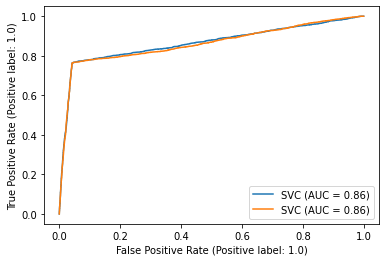

In [73]:
disp = plot_roc_curve(svm_tuned, X_test[predictors], X_test[target])
plot_roc_curve(svm,X_test[predictors], X_test[target], ax= disp.ax_);

**Learning curve after hyper parameter tuning**

In [ ]:
X_train.shape

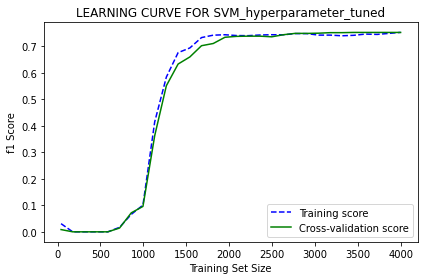

KeyboardInterrupt: 

In [81]:
disp = plot_learning_curve(svm_tuned, X, y, 'f1', 'SVM_hyperparameter_tuned')
plot_learning_curve(svm, X_train[predictors], X_train[target], 'f1', 'SVM');

## Final prediction results and performance

In [75]:
y_pred=modelfit(svm_tuned, X_train, X_final_test,predictors,target)


Model Report
Accuracy on Train Data: 0.9315
Precision on Train Data: 0.7497
Recall on Train Data: 0.7463
F1 score on Train Data: 0.748
CV Score : Mean - 0.748 | Std - 0.006003 | Min - 0.7378 | Max - 0.756
Accuracy on Test Data: 0.9313
Precision on Test Data: 0.7456
Recall on Test Data: 0.7445
F1 score on Test Data: 0.7451
Time:  681.6678728909974
